# Imports + Config

In [ ]:
import json
import requests
import pandas as pd
import numpy as np
#!pip install --upgrade typing_extensions
#!pip install pydantic
from pydantic import BaseModel
from typing import List
from typing import Union
import csv
from datetime import datetime
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import math
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch






# Ollama Config
OLLAMA_NODE = "arctrdagn041"
BASE_URL = f"http://{OLLAMA_NODE}:11434/api/chat"

model = "gemma3-optimized:27b"


## Grabbing all participant IDs that have all the PHQ-8 questionare data

In [ ]:
dev_split_phq8 = pd.read_csv(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv")
train_split_phq8 = pd.read_csv(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")
# Combining the 2 dataframes
phq8_ground_truths = pd.concat([dev_split_phq8, train_split_phq8], ignore_index=True)
# Sort by Participant_ID
phq8_ground_truths = phq8_ground_truths.sort_values('Participant_ID').reset_index(drop=True)

participant_id = 420
current_transcript = pd.read_csv(fr"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/{participant_id}_P/{participant_id}_TRANSCRIPT.csv", sep="\t")
# Reformatting transcript data to be a string with speaker name + text
current_patient_transcript = '\n'.join(current_transcript['speaker'] + ': ' + current_transcript['value'])

print(current_patient_transcript)
print("-"*50)
print(phq8_ground_truths.loc[phq8_ground_truths['Participant_ID'] == participant_id].T)


Participant: <synch>
Ellie: IntroV4Confirmation (hi i'm ellie thanks for coming in today i was created to talk to people in a safe and secure environment i'm not a therapist but i'm here to learn about people and would love to learn about you i'll ask a few questions to get us started and please feel free to tell me anything your answers are totally confidential are you ok with this)
Participant: mm
Participant: yes i am
Ellie: okay_confirm (okay)
Ellie: how_doingV (so how are you doing today)
Participant: um i'm okay
Ellie: thats_good (that's good)
Ellie: where_originally (where are you from originally)
Participant: chicago
Ellie: really (really)
Ellie: when_LA (when did you move to l_a)
Participant: um back and forth over the years and traveled a little bit
Ellie: often_backB (how often do you go back to your hometown)
Participant: haven't been out there in over fifteen sixteen years
Ellie: wow (wow)
Ellie: why2 (why)
Participant: um
Participant: kinda got stuck out here <laughter> t

## Split data into stratified Train, Validation, and Test sets

In [ ]:
# Stratify data based on Gender + PHQ8_Score
phq8_ground_truths['strat_var'] = (phq8_ground_truths['Gender'].astype(str) + '_' + 
                                phq8_ground_truths['PHQ8_Score'].astype(str))

print(f"Stratification groups (Gender_PHQ8Score):\n{phq8_ground_truths['strat_var'].value_counts().sort_index()}")


# Getting category sizes
strat_counts = phq8_ground_truths['strat_var'].value_counts()
print(f"\nCategory distribution:")
print(f"Categories with >= 3 subjects: {(strat_counts >= 3).sum()}")
print(f"Categories with 2 subjects: {(strat_counts == 2).sum()}")
print(f"Categories with 1 subject: {(strat_counts == 1).sum()}")

# Separate participants into different groups based on category size
categories_gte3 = strat_counts[strat_counts >= 3].index.tolist()
categories_eq2 = strat_counts[strat_counts == 2].index.tolist()
categories_eq1 = strat_counts[strat_counts == 1].index.tolist()

# Get participant IDs for each group
participants_gte3 = phq8_ground_truths[phq8_ground_truths['strat_var'].isin(categories_gte3)]
participants_eq2 = phq8_ground_truths[phq8_ground_truths['strat_var'].isin(categories_eq2)]
participants_eq1 = phq8_ground_truths[phq8_ground_truths['strat_var'].isin(categories_eq1)]

train_ids = []
val_ids = []
test_ids = []

# Process categories with >= 3 subjects using sklearn
if len(participants_gte3) > 0:
    # Group by category to handle small categories specially
    for category in categories_gte3:
        category_participants = participants_gte3[participants_gte3['strat_var'] == category]['Participant_ID'].tolist()
        n = len(category_participants)
        
        # Calculate ideal splits
        ideal_train = n * 0.40
        ideal_val = n * 0.30
        ideal_test = n * 0.30
        
        # Use consistent 40/30/30 split for all categories >= 3
        actual_train = round(ideal_train)
        actual_val = round(ideal_val) 
        actual_test = n - actual_train - actual_val

        # Ensure no negative values
        if actual_test < 0:
            actual_train = max(1, actual_train - 1)
            actual_test = n - actual_train - actual_val
        
        # Randomly assign participants
        np.random.seed(42)
        shuffled = category_participants.copy()
        np.random.shuffle(shuffled)
        
        train_ids.extend(shuffled[:actual_train])
        val_ids.extend(shuffled[actual_train:actual_train+actual_val])
        test_ids.extend(shuffled[actual_train+actual_val:])
        
# Process categories with exactly 2 subjects (1 for train, 1 for test)
if len(participants_eq2) > 0:
    for category in categories_eq2:
        category_participants = participants_eq2[participants_eq2['strat_var'] == category]['Participant_ID'].tolist()
        # Randomly assign 1 to train and 1 to test
        np.random.shuffle(category_participants)
        train_ids.append(category_participants[0])
        test_ids.append(category_participants[1])
    
    print(f"\nProcessed {len(participants_eq2)} participants from categories with 2 subjects")
    print(f"  {len(categories_eq2)} categories: 1 to train, 1 to test each")
    
    print(f"\nProcessed {len(participants_eq2)} participants from categories with 2 subjects")
    print(f"  {len(categories_eq2)} categories: 1 to train, 1 to validation each")

# Process categories with exactly 1 subject (all go to train)
if len(participants_eq1) > 0:
    train_ids.extend(participants_eq1['Participant_ID'].tolist())
    print(f"\nProcessed {len(participants_eq1)} participants from categories with 1 subject")
    print(f"  All {len(participants_eq1)} assigned to train set")

# Post-Prossessing Override: Handle cases where PHQ8_Score has exactly 2 participants (regardless of gender) after previous stratification takes place
phq8_score_counts = phq8_ground_truths['PHQ8_Score'].value_counts()
scores_with_2 = phq8_score_counts[phq8_score_counts == 2].index.tolist()

for score in scores_with_2:
    score_participants = phq8_ground_truths[phq8_ground_truths['PHQ8_Score'] == score]['Participant_ID'].tolist()
    
    # Remove these participants from their current assignments
    for pid in score_participants:
        if pid in train_ids:
            train_ids.remove(pid)
        if pid in val_ids:
            val_ids.remove(pid)
        if pid in test_ids:
            test_ids.remove(pid)
    
    # Reassign: 1 to validation, 1 to test
    np.random.shuffle(score_participants)
    val_ids.append(score_participants[0])
    test_ids.append(score_participants[1])
    
    print(f"Override applied for PHQ8_Score={score}: 1 to validation, 1 to test")

print(f"\nFinal split sizes:")
print(f"Train: {len(train_ids)} ({len(train_ids)/len(phq8_ground_truths)*100:.1f}%)")
print(f"Validation: {len(val_ids)} ({len(val_ids)/len(phq8_ground_truths)*100:.1f}%)")
print(f"Test: {len(test_ids)} ({len(test_ids)/len(phq8_ground_truths)*100:.1f}%)")
print(f"Total: {len(train_ids) + len(val_ids) + len(test_ids)}")

def check_balance(ids, df, split_name):
    """
    Checks the stratification balance

    Parameters
    ----------
    ids : list
        list of participant ids
    df : pandas dataframe
        dataframe of all the participant ground truth info
    split_name : string
        name of the split

    Prints
    -------
    string
        Strings giving information about the balance of the data
    """
    subset = df[df['Participant_ID'].isin(ids)]
    print(f"\n{split_name} set balance:")
    print(f"PHQ8_Binary: {subset['PHQ8_Binary'].value_counts().to_dict()}")
    print(f"Gender: {subset['Gender'].value_counts().to_dict()}")
    
    # Show PHQ8_Score distribution
    score_dist = subset['PHQ8_Score'].value_counts().sort_index()
    print(f"PHQ8_Score distribution: {dict(score_dist)}")
    print(f"Score stats: Mean={subset['PHQ8_Score'].mean():.1f}, Std={subset['PHQ8_Score'].std():.1f}")
    
    # Show how many unique categories are in this split
    unique_categories = subset['strat_var'].nunique()
    print(f"Unique categories (Gender_PHQ8Score): {unique_categories}")

check_balance(train_ids, phq8_ground_truths, "Train")
check_balance(val_ids, phq8_ground_truths, "Validation")
check_balance(test_ids, phq8_ground_truths, "Test")

# Show detailed category distribution across splits
print("\nDetailed category distribution:")
for split_name, split_ids in [("Train", train_ids), ("Val", val_ids), ("Test", test_ids)]:
    subset = phq8_ground_truths[phq8_ground_truths['Participant_ID'].isin(split_ids)]
    category_counts = subset['strat_var'].value_counts()
    print(f"\n{split_name} categories with counts:")
    for cat in sorted(category_counts.index):
        gender, score = cat.split('_')
        print(f"  Gender={gender}, PHQ8={score}: {category_counts[cat]} subjects")

# Output the three lists
print(f"\nTrain IDs ({len(train_ids)}): {train_ids}")
print(f"\nValidation IDs ({len(val_ids)}): {val_ids}")
print(f"\nTest IDs ({len(test_ids)}): {test_ids}")

Stratification groups (Gender_PHQ8Score):
0_0      9
0_1      5
0_10     4
0_11     5
0_12     3
0_13     1
0_14     1
0_15     2
0_16     2
0_18     1
0_19     1
0_2      4
0_20     3
0_23     1
0_3      3
0_4      5
0_5      2
0_6      3
0_7      4
0_8      1
0_9      3
1_0     12
1_1      6
1_10     5
1_11     2
1_12     2
1_13     1
1_14     1
1_15     1
1_16     3
1_17     1
1_18     1
1_19     1
1_2      8
1_20     1
1_3      7
1_4      5
1_5      5
1_6      2
1_7      9
1_8      3
1_9      3
Name: strat_var, dtype: int64

Category distribution:
Categories with >= 3 subjects: 23
Categories with 2 subjects: 6
Categories with 1 subject: 13

Processed 12 participants from categories with 2 subjects
  6 categories: 1 to train, 1 to test each

Processed 12 participants from categories with 2 subjects
  6 categories: 1 to train, 1 to validation each

Processed 13 participants from categories with 1 subject
  All 13 assigned to train set
Override applied for PHQ8_Score=13: 1 to validati

## Display figure for data distribution 

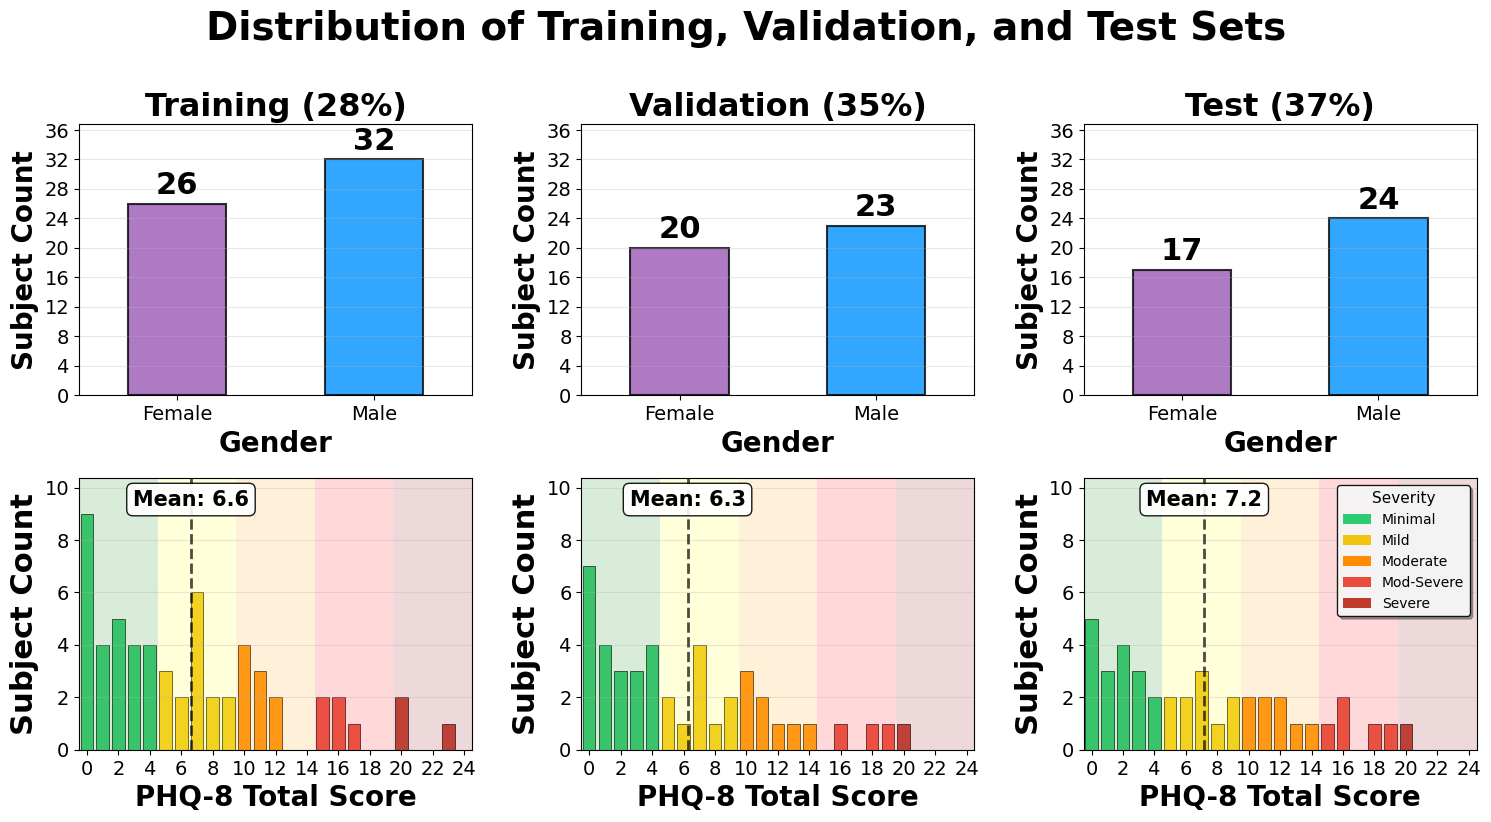


DISTRIBUTION SUMMARY

Training Set (n=58):
------------------------------
Gender Distribution:
  Female: 26 (44.8%)
  Male: 32 (55.2%)

PHQ-8 Score Statistics:
  Mean: 6.62
  Std: 5.84
  Median: 5.5
  Range: 0-23

Validation Set (n=43):
------------------------------
Gender Distribution:
  Female: 20 (46.5%)
  Male: 23 (53.5%)

PHQ-8 Score Statistics:
  Mean: 6.26
  Std: 5.62
  Median: 5.0
  Range: 0-20

Test Set (n=41):
------------------------------
Gender Distribution:
  Female: 17 (41.5%)
  Male: 24 (58.5%)

PHQ-8 Score Statistics:
  Mean: 7.17
  Std: 5.88
  Median: 6.0
  Range: 0-20


In [ ]:
# 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

gender_colors = {0: '#9b59b6', 1: "#0091ff"}  # Purple for female, orange for male

# Create color gradient for PHQ-8 scores
def get_phq8_color(score):
    if score <= 4:
        return '#2ecc71'  # Green
    elif score <= 9:
        return '#f1c40f'  # Yellow
    elif score <= 14:
        return '#ff8c00'  # Orange
    elif score <= 19:
        return '#e74c3c'  # Red
    else:
        return '#c0392b'  # Dark red

phq8_colors = {i: get_phq8_color(i) for i in range(25)}

# Dataframes for each split
train_df = phq8_ground_truths[phq8_ground_truths['Participant_ID'].isin(train_ids)]
val_df = phq8_ground_truths[phq8_ground_truths['Participant_ID'].isin(val_ids)]
test_df = phq8_ground_truths[phq8_ground_truths['Participant_ID'].isin(test_ids)]

# Split names and dataframes
splits = ['Training (41%)', 'Validation (30%)', 'Test (29%)']
split_dfs = [train_df, val_df, test_df]

# Max values for consistent y-axis scale
max_gender_count = 0
max_phq8_count = 0

# Get max gender and max PHQ8 scale
for df in split_dfs:
    gender_counts = df['Gender'].value_counts()
    if len(gender_counts) > 0:
        max_gender_count = max(max_gender_count, gender_counts.max())
    
    phq8_counts = df['PHQ8_Score'].value_counts()
    if len(phq8_counts) > 0:
        max_phq8_count = max(max_phq8_count, phq8_counts.max())

# Set consistent max y scale with padding
gender_ylim = max_gender_count * 1.15
phq8_ylim = max_phq8_count * 1.15

# Row 1: Gender Distribution
for idx, (split_name, df) in enumerate(zip(splits, split_dfs)):
    ax = axes[0, idx]
    
    # Count gender distribution
    gender_counts = df['Gender'].value_counts().sort_index()
    gender_counts = gender_counts.sort_index()
    
    # Create bar plot with different colors for each gender
    bars = ax.bar(gender_counts.index, gender_counts.values, 
                   color=[gender_colors.get(g, '#cccccc') for g in gender_counts.index],
                   edgecolor='black', linewidth=1.5, alpha=0.8, width=0.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, gender_counts.values):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                f'{int(val)}', ha='center', va='bottom', fontsize=22, fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Gender', fontsize=20, fontweight='bold')
    ax.set_ylabel('Subject Count', fontsize=20, fontweight='bold')
    ax.set_title(f'{split_name}', fontsize=23, fontweight='bold')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Female', 'Male'])
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0, gender_ylim)  # Consistent y-axis for all gender plots
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.grid(axis='y', alpha=0.3)

# Row 2: PHQ-8 Total Score Distribution
for idx, (split_name, df) in enumerate(zip(splits, split_dfs)):
    ax = axes[1, idx]
    
    # Get PHQ-8 score distribution
    phq8_scores = df['PHQ8_Score'].value_counts().sort_index()

    # Create bar plot with colors
    bars = ax.bar(phq8_scores.index, phq8_scores.values,
                    color=[phq8_colors.get(score, '#cccccc') for score in phq8_scores.index],
                    edgecolor='black', linewidth=0.5, alpha=0.9)
    
    # Add PHQ8 severity range backgrounds with outlines
    ax.axvspan(-0.5, 4.5, alpha=0.15, facecolor='green', linewidth=1.5, label='Minimal')
    ax.axvspan(4.5, 9.5, alpha=0.15, facecolor='yellow', linewidth=1.5, label='Mild')
    ax.axvspan(9.5, 14.5, alpha=0.15, facecolor='orange', linewidth=1.5, label='Moderate')
    ax.axvspan(14.5, 19.5, alpha=0.15, facecolor='red', linewidth=1.5, label='Mod-Severe')
    ax.axvspan(19.5, 24.5, alpha=0.15, facecolor='darkred', linewidth=1.5, label='Severe')
    
    # Add mean line
    mean_score = df['PHQ8_Score'].mean()
    ax.axvline(mean_score, color='black', linestyle='--', linewidth=2, alpha=0.7)
    ax.text(mean_score, phq8_ylim * 0.9, f'Mean: {mean_score:.1f}', 
            ha='center', fontsize=15, color='black', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Formatting
    ax.set_xlabel('PHQ-8 Total Score', fontsize=20, fontweight='bold')
    ax.set_ylabel('Subject Count', fontsize=22, fontweight='bold')
    ax.set_xlim(-0.5, 24.5)
    ax.set_xticks(range(0, 25, 2))
    ax.set_ylim(0, phq8_ylim)  # Consistent y-axis for all PHQ-8 plots
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.grid(axis='y', alpha=0.3)

# Legend for PHQ-8 severity ranges with border
legend_handles = [
    Patch(facecolor='#2ecc71', label='Minimal'),
    Patch(facecolor='#f1c40f', label='Mild'),
    Patch(facecolor='#ff8c00', label='Moderate'),
    Patch(facecolor='#e74c3c', label='Mod-Severe'),
    Patch(facecolor='#c0392b', label='Severe')
]

axes[1, 2].legend(handles=legend_handles, loc='upper right', fontsize=10, title='Severity', 
                title_fontsize=11, framealpha=0.9, edgecolor='black', 
                fancybox=True, shadow=True)

# Overall title
fig.suptitle('Distribution of Training, Validation, and Test Sets', 
             fontsize=28, fontweight='bold', y=1.02)

# Adjust layout spacing
plt.tight_layout(pad=1.0, h_pad=1.5, w_pad=2.5)
plt.savefig(r"/data/users2/agreene46/data_visual.pdf", bbox_inches='tight', dpi=300)
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("DISTRIBUTION SUMMARY")
print("="*60)

for split_name, df, ids in zip(['Training', 'Validation', 'Test'], 
                                split_dfs, [train_ids, val_ids, test_ids]):
    print(f"\n{split_name} Set (n={len(ids)}):")
    print("-" * 30)
    
    # Gender distribution
    gender_dist = df['Gender'].value_counts().sort_index()
    print(f"Gender Distribution:")
    for gender_val in [0, 1]:
        count = gender_dist.get(gender_val, 0)
        gender_label = "Female" if gender_val == 0 else "Male"
        print(f"  {gender_label}: {count} ({count/len(df)*100:.1f}%)" if len(df) > 0 else f"  {gender_label}: 0 (0.0%)")
    
    # PHQ-8 statistics
    if len(df) > 0:
        print(f"\nPHQ-8 Score Statistics:")
        print(f"  Mean: {df['PHQ8_Score'].mean():.2f}")
        print(f"  Std: {df['PHQ8_Score'].std():.2f}")
        print(f"  Median: {df['PHQ8_Score'].median():.1f}")
        print(f"  Range: {df['PHQ8_Score'].min()}-{df['PHQ8_Score'].max()}")
    else:
        print(f"\nNo data in this split")

## Grab knowledgebase transcripts

In [ ]:
# Dictionary with participant transcripts
participant_transcripts = {}

for participant_id in train_ids:
    try:
        current_transcript = pd.read_csv(fr"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/{participant_id}_P/{participant_id}_TRANSCRIPT.csv", sep="\t")

        # Handle missing values by converting to string and replacing NaN
        current_transcript['speaker'] = current_transcript['speaker'].fillna('Unknown').astype(str)
        current_transcript['value'] = current_transcript['value'].fillna('').astype(str)
        
        # Reformatting transcript data to be a string with speaker name + text
        current_patient_transcript = '\n'.join(current_transcript['speaker'] + ': ' + current_transcript['value'])
        participant_transcripts[participant_id] = current_patient_transcript
        
    except FileNotFoundError:
        print(f"File for participant {participant_id} not found")
        participant_transcripts[participant_id] = None
    except Exception as e:
        print(f"Error processing participant {participant_id}: {e}")
        participant_transcripts[participant_id] = None

print(len(participant_transcripts))
print(participant_transcripts)
print(f"{'-'*30}\n{len(train_ids)}")
print(train_ids)

58
{464: "Participant: <sync>\nEllie: IntroV4Confirmation (hi i'm ellie thanks for coming in today i was created to talk to people in a safe and secure environment i'm not a therapist but i'm here to learn about people and would love to learn about you i'll ask a few questions to get us started and please feel free to tell me anything your answers are totally confidential are you ok with this)\nParticipant: mhm\nEllie: okay_confirm (okay)\nEllie: how_doingV (so how are you doing today)\nParticipant: um i'm doing good what about you\nEllie: thats_good (that's good)\nEllie: great_thanks (i'm great thanks)\nParticipant: mhm\nEllie: where_originally (where are you from originally)\nParticipant: um\nParticipant: l_a <l> los los angeles but\nParticipant: i currently reside <res>reside in inglewood\nParticipant: wait did i answer your question\nEllie: cool3 (cool)\nParticipant: i don't know\nEllie: yeah3 (yeah)\nParticipant: okay\nEllie: like_about_LA (what are some things you really like abo

## Embed knowledgebase transcripts

In [ ]:
def load_existing_embeddings(pickle_file):
    """
    Loads embedded reference transcripts from pickle file

    Parameters
    ----------
    pickle_file : string
        path to the pickle file

    Returns
    -------
    dict
        Dict of embedded chunks of the reference transcripts and their participant IDs
    """
    if os.path.exists(pickle_file):
        try:
            with open(pickle_file, 'rb') as f:
                return pickle.load(f)
        except:
            print(f"Error loading {pickle_file}")
            return {}
    return {}

def save_embeddings(embeddings_dict, pickle_file):
    """
    Saves an embedding to the pickle file

    Parameters
    ----------
    embeddings_dict : dict
        The dictionary with participant IDs as keys and (raw_text, embedding) as values for each transcript chunk

    Writes
    -------
    dict
        Adds the embeddings to the pickle file
    """
    with open(pickle_file, 'wb') as f:
        pickle.dump(embeddings_dict, f)

def get_embedding(text, model="dengcao/Qwen3-Embedding-8B:Q8_0", dim=None):
    """
    Creates embedding from given text input and model 

    Parameters
    ----------
    text : string
        The text to be embedded
    model : string
        The name of the ollama model to be used for embedding
    dim : int, optional
        If provided, truncate to this dimension and normalize (MRL support)

    Returns
    -------
    list
        The vector embedding of the text
    """
    BASE_URL = f"http://{OLLAMA_NODE}:11434/api/embeddings"
    
    response = requests.post(
        BASE_URL,
        json={
            "model": model,
            "prompt": text
        }
    )
    
    if response.status_code == 200:
        embedding = response.json()["embedding"]
        
        # Manually setting dimension because ollama doesn't natively support atm
        if dim is not None:
            # Truncate and normalize for MRL models
            embedding = embedding[:dim]
            norm = math.sqrt(sum(x * x for x in embedding))
            if norm > 0:
                embedding = [x / norm for x in embedding]
        
        return embedding
    else:
        raise Exception(f"API call failed with status {response.status_code}: {response.text}")

def create_sliding_chunks(transcript_text, chunk_size=8, step_size=2):
    """
    Splits the transcript into several chunks 

    Parameters
    ----------
    transcript_text : string
        The transcript
    chunk_size : int
        The amount of newlines per chunk
    step_size : int
        The newline distance moved each time a chunk is created
            -Ex. transcript_text = "A\nB\nC\nD\nE\nF\nG\nH", chunk_size = 4, step_size = 2
            -Chunk 1: "A\nB\nC\nD"
            -Chunk 2: "C\nD\nE\nF"

    Returns
    -------
    list
        The text chunk strings
    """
    lines = transcript_text.split('\n')
    
    # Remove any empty lines at the end
    while lines and lines[-1] == '':
        lines.pop()
    
    chunks = []
    
    # If fewer lines than chunk_size, just return the whole thing
    if len(lines) <= chunk_size:
        return ['\n'.join(lines)]
    
    # Create sliding windows
    for i in range(0, len(lines) - chunk_size + 1, step_size):
        chunk = '\n'.join(lines[i:i + chunk_size])
        chunks.append(chunk)
    
    # If the last chunk doesn't include the final lines, add one more chunk
    last_chunk_start = len(lines) - chunk_size
    if last_chunk_start > 0 and (last_chunk_start % step_size) != 0:
        final_chunk = '\n'.join(lines[last_chunk_start:])
        if final_chunk not in chunks:
            chunks.append(final_chunk)
    
    return chunks

def process_transcripts(participant_transcripts, pickle_file, dim):
    """
    Chunking and embedding the reference transcripts and saving them to the pickle file

    Parameters
    ----------
    participant_transcripts : dict
        A dict of participant transcripts with the key being participant id and value being the transcript
    pickle_file : str
        The path to the pickle file

    Returns
    -------
    dict
        The dictionary with participant IDs as keys and (raw_text, embedding) as values for each transcript chunk
    """
    # Load existing embeddings
    participant_embedded_transcripts = load_existing_embeddings(pickle_file)
    
    for participant_id, transcript in participant_transcripts.items():
        # Skip if already processed
        if participant_id in participant_embedded_transcripts:
            print(f"Skipping participant {participant_id} - already processed")
            continue
        
        print(f"Processing participant {participant_id}...")
        
        try:
            # Create sliding window chunks
            chunks = create_sliding_chunks(transcript)
            
            # Get embeddings for each chunk
            embeddings_list = []
            for i, chunk in enumerate(chunks):
                print(f"  Processing chunk {i+1}/{len(chunks)}")
                embedding = get_embedding(chunk,dim=dim)
                embeddings_list.append((chunk, embedding))
            
            # Convert to numpy array and store
            participant_embedded_transcripts[participant_id] = np.array(embeddings_list, dtype=object)
            
            # Save after each participant
            save_embeddings(participant_embedded_transcripts, pickle_file)
            print(f"Completed participant {participant_id} - saved to {pickle_file}")
            
        except Exception as e:
            print(f"Error processing participant {participant_id}: {e}")
            print("Stopping processing and saving current progress...")
            save_embeddings(participant_embedded_transcripts, pickle_file)
            break
    
    return participant_embedded_transcripts

pickle_file = "/data/users2/agreene46/ai-psychiatrist/chunk_8_step_2_dim_64_participant_embedded_transcripts.pkl"
participant_embedded_transcripts = process_transcripts(participant_transcripts, pickle_file, 64)

Processing participant 464...
  Processing chunk 1/222
  Processing chunk 2/222
  Processing chunk 3/222
  Processing chunk 4/222
  Processing chunk 5/222
  Processing chunk 6/222
  Processing chunk 7/222
  Processing chunk 8/222
  Processing chunk 9/222
  Processing chunk 10/222
  Processing chunk 11/222
  Processing chunk 12/222
  Processing chunk 13/222
  Processing chunk 14/222
  Processing chunk 15/222
  Processing chunk 16/222
  Processing chunk 17/222
  Processing chunk 18/222
  Processing chunk 19/222
  Processing chunk 20/222
  Processing chunk 21/222
  Processing chunk 22/222
  Processing chunk 23/222
  Processing chunk 24/222
  Processing chunk 25/222
  Processing chunk 26/222
  Processing chunk 27/222
  Processing chunk 28/222
  Processing chunk 29/222
  Processing chunk 30/222
  Processing chunk 31/222
  Processing chunk 32/222
  Processing chunk 33/222
  Processing chunk 34/222
  Processing chunk 35/222
  Processing chunk 36/222
  Processing chunk 37/222
  Processing chun

## Grabbing evidence from transcript

In [ ]:
evidence_extraction_prompt = f"""Analyze the following therapy transcript and extract specific text chunks that provide evidence for each PHQ-8 domain. Based on the evidence found, determine the appropriate PHQ-8 score for each domain.

PHQ-8 scoring reference:
- 0 = not at all (0-1 days)
- 1 = several days (2-6 days) 
- 2 = more than half the days (7-11 days)
- 3 = nearly every day (12-14 days)

For each domain below, extract direct quotes from the transcript that indicate the presence, absence, frequency, or severity of symptoms. Then determine the most appropriate score based on the evidence.

PHQ-8 domains:
- nointerest: little interest or pleasure in activities
- depressed: feeling down, depressed, or hopeless
- sleep: sleep problems (trouble falling/staying asleep or sleeping too much)
- tired: feeling tired or having little energy
- appetite: appetite changes (poor appetite or overeating)
- failure: negative self-perception or feeling like a failure
- concentrating: trouble concentrating on tasks
- moving: psychomotor changes (moving/speaking slowly or restlessness)

Return a JSON object with arrays of relevant transcript quotes for each domain. Each quote should be a direct excerpt from the transcript that supports your scoring decision. Include as many relevant quotes as you find - this could range from 0 quotes (if no evidence) to multiple quotes per domain.

Therapy transcript:
{current_patient_transcript}

Respond with valid JSON matching this structure:
{{
    "PHQ8_NoInterest": ["evidence_1", "evidence_2", "evidence_3", "evidence_4"],
    "PHQ8_Depressed": ["evidence_1"],
    "PHQ8_Sleep": ["evidence_1", "evidence_2", "evidence_3"],
    "PHQ8_Tired": ["evidence_1", "evidence_2"],
    "PHQ8_Appetite": [],
    "PHQ8_Failure": ["evidence_1", "evidence_2", "evidence_3", "evidence_4", "evidence_5"],
    "PHQ8_Concentrating": ["evidence_1"],
    "PHQ8_Moving": ["evidence_1", "evidence_2"]
}}

Important: Extract UNIQUE quotes only - do not repeat the same quote multiple times. Each quote should be different and provide distinct, related evidence. If no evidence exists for a domain, return an empty array for that domain. Also, do not format the evidence grabbed in any way, output it EXACTLY as it is in the transcript.
"""

response = requests.post(
    BASE_URL,
    json={
        "model": model,
        "messages": [{"role": "user", "content": evidence_extraction_prompt}],
        "options": {
            # Fairly deterministic parameters
            "temperature": 0.2,
            "top_k": 20,
            "top_p": 0.8
        }
    }
)

# Get the full response directly
response_json = response.json()
full_response = response_json['message']['content']

# Use the full_response for processing
content = full_response.strip('```json\n').strip('\n```')

try:
    evidence_dict = json.loads(content)
    
    # Add scores to the output
    scores = phq8_ground_truths.iloc[13]
    evidence_dict['scores'] = {
        'PHQ8_NoInterest': int(scores['PHQ8_NoInterest']),
        'PHQ8_Depressed': int(scores['PHQ8_Depressed']),
        'PHQ8_Sleep': int(scores['PHQ8_Sleep']),
        'PHQ8_Tired': int(scores['PHQ8_Tired']),
        'PHQ8_Appetite': int(scores['PHQ8_Appetite']),
        'PHQ8_Failure': int(scores['PHQ8_Failure']),
        'PHQ8_Concentrating': int(scores['PHQ8_Concentrating']),
        'PHQ8_Moving': int(scores['PHQ8_Moving'])
    }
    
    # Remove duplicate quotes in each evidence list
    for key in evidence_dict:
        if isinstance(evidence_dict[key], list):
            evidence_dict[key] = list(dict.fromkeys(evidence_dict[key]))
    
    formatted_output = json.dumps(evidence_dict, indent=4)
    print(formatted_output)
    
except json.JSONDecodeError as e:
    print(f"Error parsing JSON: {e}")
    print(f"Raw content: {content}")


KeyboardInterrupt: 

## Embedding the evidence given

In [ ]:
def find_similar_chunks(evidence_text_embedding, participant_embedded_transcripts, top_k=3):
    """
    Runs cosine similarity between the evidence and all of the reference transcript embedded chunks.
    Then, grabs the top_k most similar ones.

    Parameters
    ----------
    evidence_text_embedding : list
        The embedding of the pulled evidence from the current transcript for the given PHQ8 question
    participant_embedded_transcripts : dict
        The dictionary with participant IDs as keys and (raw_text, embedding) as values for each transcript chunk
    top_k : int
        The number of most similar chunks that should be pulled (ex. top_k=3 means pull the 3 most similar chunks)

    Returns
    -------
    list
        List of dictionaries containing the most similar chunks, each with keys:
        'participant_id', 'raw_text', 'similarity', and 'embedding'.
        Sorted by similarity score in descending order.
    """
    similarities = []
    
    # Go through all participants and their embeddings
    for participant_id, embeddings_array in participant_embedded_transcripts.items():
        for i, (raw_text, embedding) in enumerate(embeddings_array):
            # Calculate cosine similarity
            similarity = cosine_similarity(
                [evidence_text_embedding], 
                [embedding]
            )[0][0]
            
            similarities.append({
                'participant_id': participant_id,
                'raw_text': raw_text,
                'similarity': similarity,
                'embedding': embedding
            })
    
    # Sort by similarity and get top_k amount
    similarities.sort(key=lambda x: x['similarity'], reverse=True)
    return similarities[:top_k]

def process_evidence_for_references(evidence_dict, participant_embedded_transcripts, phq8_ground_truths, top_k):
    """
    Grabs chunks from other transcripts that are similar to the evidence pulled for the current transcript.
    Then, grabs those chunks ground truth scores and formats all that into a string for use in the prompt.

    Parameters
    ----------
    evidence_dict : dict
        Dictionary containing PHQ-8 domain keys mapped to lists of evidence quotes
    
    participant_embedded_transcripts : dict
        The dictionary with participant IDs as keys and (raw_text, embedding) as values for each transcript chunk
    
    phq8_ground_truths : pandas dataframe
        Dataframe containing ground truth PHQ-8 scores for participants
    
    Returns
    -------
    str
        A string with all the reference transcripts chunks and their corresponding PHQ8 scores
    """
    evidence_keys = [
        'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
        'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving'
    ]
    
    all_references = []
    
    for evidence_key in evidence_keys:
        # Get evidence texts for this key
        evidence_texts = evidence_dict.get(evidence_key, [])
        
        # Skip if empty
        if not evidence_texts:
            continue
        
        # Combine evidence texts into single string
        combined_text = '\n'.join(evidence_texts)
        
        # Skip if less than 15 characters
        if len(combined_text) < 15:
            continue
        
        print(f"Processing {evidence_key}...")
        
        try:
            # Get embedding for combined evidence text
            evidence_embedding = get_embedding(combined_text)
            
            # Find top_k similar chunks
            similar_chunks = find_similar_chunks(
                evidence_embedding, 
                participant_embedded_transcripts, 
                top_k=top_k
            )
            
            # Add each reference with its own header
            for chunk_info in similar_chunks:
                participant_id = chunk_info['participant_id']
                raw_text = chunk_info['raw_text']
                
                # Get the ground truth score for this participant and evidence type
                participant_data = phq8_ground_truths.loc[
                    phq8_ground_truths['Participant_ID'] == participant_id
                ]
                
                if not participant_data.empty:
                    score = int(participant_data[evidence_key].values[0])
                    reference_entry = f"({evidence_key} Score: {score})\n{raw_text}"
                    all_references.append(reference_entry)
                else:
                    print(f"Warning: No ground truth data found for participant {participant_id}")
                
        except Exception as e:
            print(f"Error processing {evidence_key}: {e}")
            continue
    
    # Combine all references into a string
    if all_references:
        reference_evidence = "<Reference Examples>\n\n" + "\n\n".join(all_references) + "\n\n<Reference Examples>"
    else:
        reference_evidence = "<Reference Examples>\nNo valid evidence found\n<Reference Examples>"
    
    return reference_evidence

reference_evidence = process_evidence_for_references(
    evidence_dict, 
    participant_embedded_transcripts, 
    phq8_ground_truths,
    top_k=3,
)
print()
print(reference_evidence)

Processing PHQ8_Depressed...
Processing PHQ8_Sleep...
Processing PHQ8_Tired...
Processing PHQ8_Failure...

<Reference Examples>

(PHQ8_Depressed Score: 1)
Participant: it's a little strange
Ellie: how have you been feeling lately
Participant: how i've been feeling lately
Participant: a little uneasy

(PHQ8_Depressed Score: 1)
Participant: yes
Ellie: okay
Ellie: so how are you doing today
Participant: i'm a little nervous

(PHQ8_Depressed Score: 1)
Participant: very <v> just very irritable
Ellie: okay
Ellie: how have you been feeling lately 
Participant: um i was feeling anxious but now i'm calmer

(PHQ8_Sleep Score: 2)
Ellie: how easy is it for you to get a good night's sleep
Participant: almost impossible ever since i was a little kid i had a i had trouble falling asleep and um
Participant: about four years ago it it became really really bad where i just couldn't sleep through the night i was getting about four hours of sleep 
Participant: sometimes i would wake up every hour and i'd 

## Run Quantitative Analysis

In [ ]:
class PHQ8ScoreWithExplanation(BaseModel):
    evidence: str  # Direct quotes or references from interview
    reason: str  # Brief explanation for the score
    score: Union[int, str]  # 0-3 or "N/A"

class PHQ8ScoresWithExplanations(BaseModel):
    PHQ8_NoInterest: PHQ8ScoreWithExplanation  # Little interest or pleasure in doing things
    PHQ8_Depressed: PHQ8ScoreWithExplanation   # Feeling down, depressed, or hopeless
    PHQ8_Sleep: PHQ8ScoreWithExplanation       # Trouble falling/staying asleep, or sleeping too much
    PHQ8_Tired: PHQ8ScoreWithExplanation       # Feeling tired or having little energy
    PHQ8_Appetite: PHQ8ScoreWithExplanation    # Poor appetite or overeating
    PHQ8_Failure: PHQ8ScoreWithExplanation     # Feeling bad about self or like a failure
    PHQ8_Concentrating: PHQ8ScoreWithExplanation # Trouble concentrating
    PHQ8_Moving: PHQ8ScoreWithExplanation      # Moving/speaking slowly or being fidgety/restless

system_prompt = """You are a AI psychiatrist assessment tool specialized in analyzing interview transcripts to evaluate PHQ-8 (Patient Health Questionnaire-8) scores. The PHQ-8 is a validated depression screening instrument that assesses eight of the nine DSM-IV criteria for depressive disorders over the past 2 weeks.

PHQ-8 Scoring System:
- 0 = Not at all (0-1 days in the past 2 weeks)
- 1 = Several days (2-6 days)
- 2 = More than half the days (7-11 days)
- 3 = Nearly every day (12-14 days)

Key Principles:
1. Base all assessments strictly on evidence from the transcript
2. When no relevant evidence exists for a symptom, output "N/A" rather than assuming absence (score of 0)
3. Consider both explicit statements and behavioral indicators in the interview
4. Be conservative - only assign scores when there is clear evidence of frequency
5. Remember that absence of mention does not necessarily mean absence of symptom
6. When reference examples are provided, use them for cross-analysis to inform scoring decisions
7. Weight reference examples based on their similarity to the current evidence - highly similar references should be considered more heavily
8. Follow the format specified exactly"""

def run_phq8_analysis(patient_transcript, ground_truth, reference_evidence=""):
    """
    Predicts PHQ8 values from a patients transcript, compares to ground truth, and calculates evaluation metrics

    Parameters
    ----------
    patient_transcript : string
        The patients transcript
    ground_truth : pandas series
        The ground truth PHQ8 values for a given participant

    Returns
    -------
    tuple
        A 5-tuple containing:
        - phq8_scores (PHQ8ScoresWithExplanations or None): Parsed PHQ8 scores with evidence and reasoning
        - avg_difference (float or None): Average absolute difference between predicted and ground truth scores
        - accuracy_on_available (float or None): Accuracy score on questions that weren't marked N/A (0-1 scale)
        - num_questions_NA (int or None): Number of questions marked as N/A out of 8 total
        - overall_accuracy (float or None): Overall accuracy adjusted for N/A responses (0-1 scale)
        
        Returns (None, None, None, None, None) if parsing fails.
    """
    quantitative_prompt = f"""Analyze the following interview transcript and predict PHQ-8 scores for each symptom domain.

Interview transcript:
<transcript>
{patient_transcript}
</transcript>

{reference_evidence}

Analyze each symptom using the following approach in <thinking> tags:
1. Search for direct quotes or behavioral evidence related to each PHQ-8 symptom
2. When reference examples are provided, compare the current evidence with similar reference cases
3. Evaluate the frequency/severity based on available evidence and reference comparisons
4. Consider how similar the reference examples are to the current evidence - if highly similar, give more weight to the reference scores; if less similar, rely more on direct analysis
5. If no relevant evidence exists, mark as "N/A" rather than assuming absence
6. Only assign numeric scores (0-3) when evidence clearly indicates frequency

After your analysis, provide your final assessment in <answer> tags as a JSON object.

For each symptom, provide:
1. "evidence": exact quotes from transcript (use "No relevant evidence found" if not discussed)
2. "reason": explanation of scoring decision, including cross-reference analysis when applicable and why N/A if applicable
3. "score": integer 0-3 based on evidence, or "N/A" if no relevant evidence

Return ONLY a JSON object in <answer> tags with these exact keys:
- "PHQ8_NoInterest": {{evidence, reason, score}} for little interest or pleasure in doing things (anhedonia)
- "PHQ8_Depressed": {{evidence, reason, score}} for feeling down, depressed, or hopeless (depressed mood)
- "PHQ8_Sleep": {{evidence, reason, score}} for trouble falling or staying asleep, or sleeping too much (sleep problems)
- "PHQ8_Tired": {{evidence, reason, score}} for feeling tired or having little energy (fatigue)
- "PHQ8_Appetite": {{evidence, reason, score}} for poor appetite or overeating (appetite/weight changes)
- "PHQ8_Failure": {{evidence, reason, score}} for feeling bad about yourself or that you are a failure (negative self-perception)
- "PHQ8_Concentrating": {{evidence, reason, score}} for trouble concentrating on things like reading or watching TV (concentration problems)
- "PHQ8_Moving": {{evidence, reason, score}} for moving or speaking slowly, or being fidgety/restless (psychomotor changes)"""

    response = requests.post(
        BASE_URL,
        json={
            "model": model,
            "messages": [{"role": "system", "content": system_prompt},
                        {"role": "user", "content": quantitative_prompt}],
            "options": {
                # Fairly deterministic parameters
                "temperature": 0.2,
                "top_k": 20,
                "top_p": 0.8
            }
        }
    )

    # Get the full response directly
    response_data = response.json()
    full_response = response_data['message']['content']

    # Parse and validate the response
    try:
        content = full_response
        
        # Extract content from <answer> tags if present
        if '<answer>' in content and '</answer>' in content:
            content = content.split('<answer>')[1].split('</answer>')[0].strip()
        
        # Remove markdown code blocks if present
        if content.startswith('```json'):
            content = content.split('```json')[1].split('```')[0].strip()
        elif content.startswith('```'):
            content = content.split('```')[1].split('```')[0].strip()
        
        # Parse the JSON response and validate with Pydantic
        scores_dict = json.loads(content)
        phq8_scores = PHQ8ScoresWithExplanations(**scores_dict)
        
        # Extract the 8 PHQ-8 score values
        scores_list = [
            phq8_scores.PHQ8_NoInterest.score,
            phq8_scores.PHQ8_Depressed.score,
            phq8_scores.PHQ8_Sleep.score,
            phq8_scores.PHQ8_Tired.score,
            phq8_scores.PHQ8_Appetite.score,
            phq8_scores.PHQ8_Failure.score,
            phq8_scores.PHQ8_Concentrating.score,
            phq8_scores.PHQ8_Moving.score
        ]
        
        print("Comparison of Predicted vs Ground Truth:")
        print("Metric\t\t\tPredicted\tGround Truth\tDifference")
        print("-" * 65)

        differences = []
        n_available = 0
        num_questions_NA = 0
        metrics = ['PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired', 
                'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving']
        predicted_values = [phq8_scores.PHQ8_NoInterest.score, phq8_scores.PHQ8_Depressed.score, phq8_scores.PHQ8_Sleep.score, 
                        phq8_scores.PHQ8_Tired.score, phq8_scores.PHQ8_Appetite.score, phq8_scores.PHQ8_Failure.score,
                        phq8_scores.PHQ8_Concentrating.score, phq8_scores.PHQ8_Moving.score]

        for metric, pred_val in zip(metrics, predicted_values):
            print(f"DEBUG: Processing {metric}")
            print(f"DEBUG: pred_val = {pred_val}, type = {type(pred_val)}")
            print(f"DEBUG: ground_truth[metric] = {ground_truth[metric]}, type = {type(ground_truth[metric])}")
            
            gt_val = int(ground_truth[metric].iloc[0] if hasattr(ground_truth[metric], 'iloc') else ground_truth[metric])
            print(f"DEBUG: gt_val = {gt_val}, type = {type(gt_val)}")
            
            if pred_val == "N/A":
                diff_str = "N/A"
                num_questions_NA += 1
                print(f"DEBUG: pred_val is N/A")
            else:
                # Convert pred_val to int if it's a string representation of a number
                try:
                    pred_val_int = int(pred_val)
                    print(f"DEBUG: converted pred_val to int: {pred_val_int}")
                except (ValueError, TypeError):
                    print(f"DEBUG: Could not convert pred_val '{pred_val}' to int, treating as N/A")
                    diff_str = "N/A"
                    num_questions_NA += 1
                    continue
                    
                diff = abs(pred_val_int - gt_val)
                differences.append(diff)
                diff_str = str(diff)
                n_available += 1
                print(f"DEBUG: diff = {diff}")
            
            print(f"{metric:<23} {str(pred_val):<12} {gt_val:<15} {diff_str}")
            print("DEBUG: ---")

        # Calculate metrics
        if n_available > 0:
            avg_difference = sum(differences) / n_available
            accuracy_on_available = 1 - (avg_difference / 3)
        else:
            avg_difference = float('inf')
            accuracy_on_available = 0
        
        # Accuracy * % available questions
        overall_accuracy = accuracy_on_available * (1 - (num_questions_NA / 8))
        
        print("-" * 65)
        if n_available > 0:
            print(f"Average Absolute Difference (on available): {avg_difference:.2f}")
            print(f"Accuracy on available questions: {accuracy_on_available:.2%}")
        print(f"Questions marked N/A: {num_questions_NA}/8")
        print(f"Overall accuracy: {overall_accuracy:.2%}")
        
        # Reasoning and evidence section
        print("\n\nDetailed Reasoning for Each Score:")
        print("=" * 80)

        for key in metrics:
            score_data = getattr(phq8_scores, key)
            print(f"\n{key} (Score: {score_data.score})")
            print("-" * 40)
            print(f"Evidence: {score_data.evidence}")
            print(f"Reason: {score_data.reason}")

        return phq8_scores, avg_difference, accuracy_on_available, num_questions_NA, overall_accuracy

    except (json.JSONDecodeError, KeyError, ValueError) as e:
        print(f"Error parsing response: {e}")
        print("Raw response:", response)
        print(json.dumps(response.json(), indent=2))
        return None, None, None, None, None

run_phq8_analysis(current_patient_transcript, phq8_ground_truths, reference_evidence)
print()

Comparison of Predicted vs Ground Truth:
Metric			Predicted	Ground Truth	Difference
-----------------------------------------------------------------
DEBUG: Processing PHQ8_NoInterest
DEBUG: pred_val = 0, type = <class 'str'>
DEBUG: ground_truth[metric] = 0      1
1      0
2      0
3      0
4      0
      ..
137    0
138    0
139    0
140    1
141    0
Name: PHQ8_NoInterest, Length: 142, dtype: int64, type = <class 'pandas.core.series.Series'>
DEBUG: gt_val = 1, type = <class 'int'>
DEBUG: converted pred_val to int: 0
DEBUG: diff = 1
PHQ8_NoInterest         0            1               1
DEBUG: ---
DEBUG: Processing PHQ8_Depressed
DEBUG: pred_val = 1, type = <class 'str'>
DEBUG: ground_truth[metric] = 0      1
1      0
2      1
3      1
4      1
      ..
137    0
138    1
139    1
140    1
141    0
Name: PHQ8_Depressed, Length: 142, dtype: int64, type = <class 'pandas.core.series.Series'>
DEBUG: gt_val = 1, type = <class 'int'>
DEBUG: converted pred_val to int: 1
DEBUG: diff = 0
PHQ8_D